In [137]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


In [2]:
DATA_ROOT = Path('../../data')
IMAGE_1_NAME = Path('tsukuba_l.png')
IMAGE_2_NAME = Path('tsukuba_r.png')

In [3]:
# load images
img1 = cv2.imread(str(DATA_ROOT/IMAGE_1_NAME))
img2 = cv2.imread(str(DATA_ROOT/IMAGE_2_NAME))

In [45]:
# calculate dense optical flow

# convert to gray scale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# calculate optical flow
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 10, 25, 9, 5, 1.2, 0)
of_mag, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

In [31]:
# calculate dense disparity map from stereo images
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=21)

# compute disparity
disparity = stereo.compute(gray1,gray2)

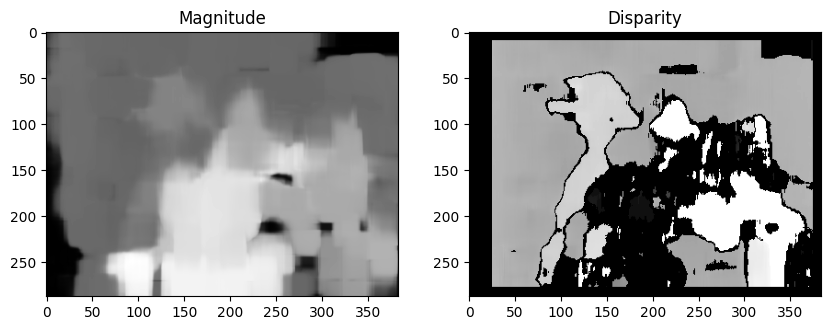

In [32]:
# display magnitude and disparity

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(of_mag, cmap='gray')
ax[0].set_title('Magnitude')
ax[1].imshow(disparity, cmap='gray')
ax[1].set_title('Disparity')
plt.show()

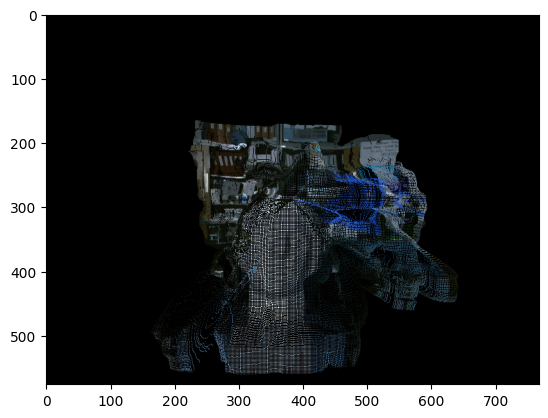

In [60]:
# zoom into the image based on magnitudes
def zoom(img1: np.ndarray, zoom_scale_map: np.ndarray, magnitude: float = 1.0) -> np.ndarray:
    # get the shape of the image
    height, width, _ = img1.shape
    # create a new image
    new_img = np.zeros((height*2, width*2, 3), dtype=np.uint8)
    # normalize the zoom scale map
    zoom_scale_map = zoom_scale_map / np.max(zoom_scale_map)
    zoom_scale_map = zoom_scale_map - 0.5
    zoom_scale_map = zoom_scale_map * magnitude
    # loop through the image
    for i in range(height):
        for j in range(width):
            # get the zoom scale
            zoom_scale = zoom_scale_map[i, j] * -1
            # get the new coordinates
            new_i = int(i + (height / 2 - i) * zoom_scale) + height // 2
            new_j = int(j + (width / 2 - j) * zoom_scale) + width // 2
            # check if the new coordinates are in the range
            if new_i < 0 or new_i >= 2*height or new_j < 0 or new_j >= 2*width:
                continue
            # copy the pixel
            new_img[new_i, new_j] = img1[i, j]
    return new_img

# plot
zoom_frame = zoom(img1, of_mag, 2.0)
plt.imshow(zoom_frame)
plt.show()

In [140]:
start_magnitude = 0.1
end_magnitude = 5.0
step = 0.1
frames = []
for magnitude in tqdm(np.arange(start_magnitude, end_magnitude, step)):
    frame = zoom(img1, of_mag, magnitude)
    frames.append(frame)
frames = [Image.fromarray(img) for img in frames]
frames[0].save("zoom_pc.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:37<00:00,  1.31it/s]


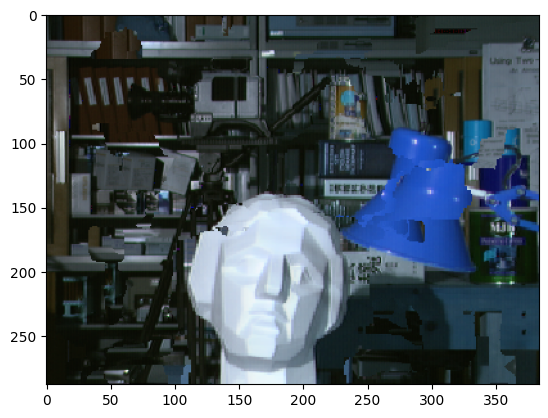

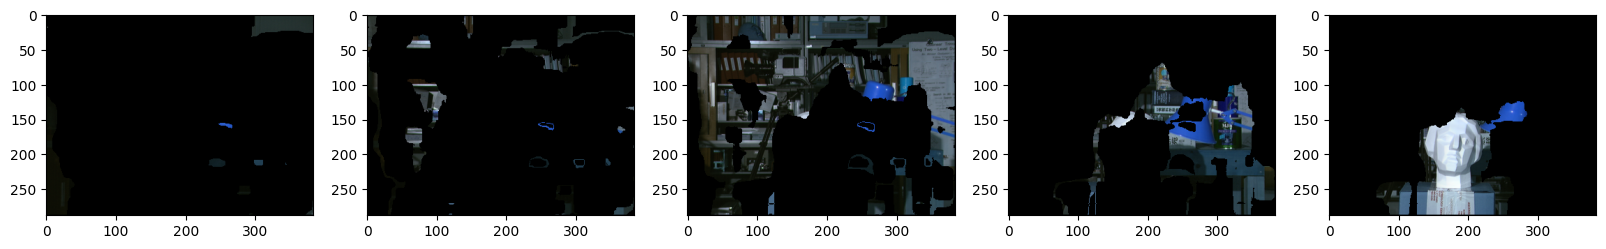

In [134]:
def bucketize(value, min_value, max_value, num_buckets):
    # Compute the size of each bucket
    bucket_size = (max_value - min_value) / num_buckets

    # Compute the index of the bucket that the value belongs to
    bucket = int((value - min_value) / bucket_size)

    # Make sure the bucket index is within range
    bucket = max(0, min(bucket, num_buckets - 1))

    return bucket

def crop_or_pad(image, target_width, target_height):
    # Compute the image's current width and height
    image_width = image.shape[1]
    image_height = image.shape[0]

    # Compute the width and height difference
    image_width_diff = image_width - target_width
    image_height_diff = image_height - target_height

    # Crop the image if needed
    if image_width_diff > 0 or image_height_diff > 0:
        # Compute the cropping parameters
        crop_left = image_width_diff // 2
        crop_right = crop_left if image_width_diff % 2 == 0 else crop_left + 1
        crop_top = image_height_diff // 2
        crop_bottom = crop_top if image_height_diff % 2 == 0 else crop_top + 1

        # Crop the image
        image = image[crop_top:-crop_bottom, crop_left:-crop_right, :]

    # Pad the image if needed
    if image_width_diff < 0 or image_height_diff < 0:
        # Compute the padding parameters
        pad_left = -image_width_diff // 2
        if image_width_diff % 2 == 0:
            pad_right = pad_left
        else:
            pad_right = pad_left + 1
        pad_top = -image_height_diff // 2
        if image_height_diff % 2 == 0:
            pad_bottom = pad_top
        else:
            pad_bottom = pad_top + 1

        # Pad the image
        image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_DEFAULT)
    assert image.shape[0] == target_height and image.shape[1] == target_width
    return image

def copy_non_black_pixels(dest_image: np.ndarray, source_image: np.ndarray) -> np.ndarray:
    return np.where(source_image != np.array([0, 0, 0]), source_image, dest_image)


def zoom_planes(img1, zoom_scale_map: np.ndarray, number_of_planes = 5, magnitude: float = 1.0) -> np.ndarray:
    normalized_zoom_scale_map = zoom_scale_map / np.max(zoom_scale_map)
    width, height = img1.shape[1], img1.shape[0]
    planes = np.zeros((height,width, 3, number_of_planes), dtype=np.uint8)
    for i in range(width):
        for j in range(height):
            # get bucketised zoom scale
            plane_index = bucketize(normalized_zoom_scale_map[j, i], 0.0, 1.0, number_of_planes)
            # set the plane value
            planes[j, i,:, plane_index] = img1[j, i, :]
    zoom_img = np.copy(img1) # np.zeros((height,width, 3), dtype=np.uint8)
    for i in range(number_of_planes):
        zoom_factor = 2 ** ((0.5 + i - (number_of_planes // 2)) * (magnitude/10)) + 0.1
        zoom_img_width = int(width * zoom_factor)
        zoom_img_height = int(height * zoom_factor)
        zoomed_plane = cv2.resize(planes[:, :, :, i], (zoom_img_width, zoom_img_height), interpolation=cv2.INTER_NEAREST)
        # cropt the center
        zoomed_plane = crop_or_pad(zoomed_plane, width, height)
        # copy non-zero values
        zoom_img = copy_non_black_pixels(zoom_img, zoomed_plane)
    return zoom_img, planes

# plot
zoom_frame, planes = zoom_planes(img1, of_mag, 5, 2.0)
plt.imshow(zoom_frame)
plt.show()

# ploat planes
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(planes[:, :, :, i])
plt.show()

In [141]:
# imgs = [Image.fromarray(img) for img in imgs]
# # duration is the number of milliseconds between frames; this is 40 frames per second
# imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

start_magnitude = 0.1
end_magnitude = 4.0
step = 0.1
frames = []
for magnitude in tqdm(np.arange(start_magnitude, end_magnitude, step)):
    frame,_ = zoom_planes(img1, of_mag, 9, magnitude)
    frames.append(frame)

frames = [Image.fromarray(img) for img in frames]
frames[0].save("zoom_pl.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:31<00:00,  1.23it/s]
